In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import catalyst.dl as dl
from catalyst.dl import Experiment
from datasets import CirclesDataSet
from datasets import DatasetImbalanced
from models.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from runners import ClassificationRunner
from sklearn.metrics import balanced_accuracy_score
from models.metrics import average_precision_metric
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import io
import cv2
from callabacks import DicisionBoundryCallback, HypernetVisualization
from vis_utils import visualize_dataset
from catalyst.dl import utils
from models.networks import CirclesHyperNetwork

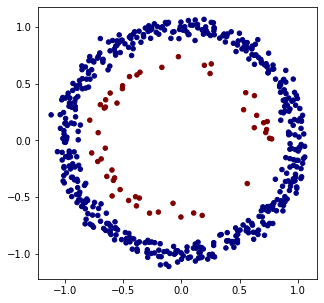

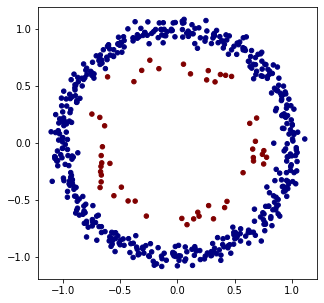

In [2]:
circles_train = CirclesDataSet(train=True, n_samples=1000, noise=0.05, transform=ToTensor(), target_transform=ToTensor())
circles_train = DatasetImbalanced(imbalance_ratio=0.1)(circles_train)
visualize_dataset(circles_train.data, circles_train.target)
circles_test = CirclesDataSet(train=False, n_samples=1000, noise=0.05,  transform=ToTensor(), target_transform=ToTensor())
circles_test = DatasetImbalanced(imbalance_ratio=0.1)(circles_test)
visualize_dataset(circles_test.data, circles_test.target)
pass

## Model

In [3]:
classifier = nn.Sequential(
    nn.Linear(2, 32), nn.ReLU(), 
    nn.Linear(32, 32), nn.ReLU(), 
    nn.Linear(32, 1)
)
generator = nn.Sequential(
            nn.Linear(2, 32),  
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 2)
            )
encoder = nn.Identity()
hypernetwork = CirclesHyperNetwork(classifier)

## Classification Experiment

In [ ]:
SEED = 42
utils.set_global_seed(SEED)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(circles_train.pos_weight))
model = {
         "classifier": classifier,
         "encoder": encoder}

optimizer = torch.optim.Adam(model['classifier'].parameters(), lr=0.0003, betas=(0.5, 0.999))
logdir = './experiments/circles/classification'
loaders = {
    "train": DataLoader(circles_train, batch_size=64, shuffle=True), 
    "valid": DataLoader(circles_test, batch_size=64, shuffle=False), 
}

experiment_train = Experiment(model=model,
                              criterion=criterion,
                              optimizer=optimizer,
                              loaders=loaders,
                              logdir=logdir,
                              main_metric="mAP",
                              minimize_metric=False,
                              # scheduler=scheduler,
                              num_epochs=100,
                              callbacks=[
                                  dl.CriterionCallback(),
                                  dl.LoaderMetricCallback(input_key="targets",
                                                          output_key="logits",
                                                          prefix="mAP",
                                                          metric_fn=average_precision_metric),
                                  dl.LoaderMetricCallback(input_key="targets",
                                                          output_key="preds",
                                                          prefix="BalancedAccuracy",
                                                          metric_fn=balanced_accuracy_score),
                                  dl.OptimizerCallback(),
                                  # dl.SchedulerCallback()
                                  DicisionBoundryCallback(),
                                  dl.TensorboardLogger()
                              ])


runner = ClassificationRunner()
runner.run_experiment(experiment_train)

## HyperNet Experiment

In [24]:
SEED = 42
utils.set_global_seed(SEED)

checkpoint = utils.load_checkpoint('./experiments/circles/classification/checkpoints/last.pth')['model_state_dict']
classifier.load_state_dict(checkpoint['classifier'])

criterion = torch.nn.BCEWithLogitsLoss()


model = {
         "encoder": encoder,
         "classifier": classifier,
         "hypernetwork": hypernetwork}

hypernetwork._generate_synthetic_points(samples=200)
params = hypernetwork.x_syn
optimizer = torch.optim.Adam([params], lr=0.03, betas=(0.5, 0.999))

logdir = './experiments/circles/hyper'

loaders = {
    "train": DataLoader(circles_train, batch_size=64, shuffle=True) 
#     "valid": DataLoader(circles_test, batch_size=64, shuffle=False), 
}

experiment_train = Experiment(model=model,
                              criterion=criterion,
                              optimizer=optimizer,
                              loaders=loaders,
                              logdir=logdir,
                              minimize_metric=True,
                              num_epochs=100,
                              callbacks=[
                                  dl.CriterionCallback(),
                                  dl.OptimizerCallback(),
                                  HypernetVisualization(),
                                  dl.TensorboardLogger()
                              ])


runner = ClassificationRunner(use_hyper_network=True)
runner.run_experiment(experiment_train)

[2021-03-01 15:39:11,323] 
1/100 * Epoch 1 (_base): lr=0.0300 | momentum=0.5000
1/100 * Epoch 1 (train): loss=1.7291
[2021-03-01 15:39:11,407] 
2/100 * Epoch 2 (_base): lr=0.0300 | momentum=0.5000
2/100 * Epoch 2 (train): loss=1.0497
[2021-03-01 15:39:11,490] 
3/100 * Epoch 3 (_base): lr=0.0300 | momentum=0.5000
3/100 * Epoch 3 (train): loss=0.5848
[2021-03-01 15:39:11,576] 
4/100 * Epoch 4 (_base): lr=0.0300 | momentum=0.5000
4/100 * Epoch 4 (train): loss=0.3125
[2021-03-01 15:39:11,660] 
5/100 * Epoch 5 (_base): lr=0.0300 | momentum=0.5000
5/100 * Epoch 5 (train): loss=0.1753
[2021-03-01 15:39:11,743] 
6/100 * Epoch 6 (_base): lr=0.0300 | momentum=0.5000
6/100 * Epoch 6 (train): loss=0.1245
[2021-03-01 15:39:11,828] 
7/100 * Epoch 7 (_base): lr=0.0300 | momentum=0.5000
7/100 * Epoch 7 (train): loss=0.1071
[2021-03-01 15:39:11,915] 
8/100 * Epoch 8 (_base): lr=0.0300 | momentum=0.5000
8/100 * Epoch 8 (train): loss=0.0995
[2021-03-01 15:39:12,003] 
9/100 * Epoch 9 (_base): lr=0.0300 | 

[2021-03-01 15:39:17,801] 
70/100 * Epoch 70 (_base): lr=0.0300 | momentum=0.5000
70/100 * Epoch 70 (train): loss=0.0761
[2021-03-01 15:39:17,889] 
71/100 * Epoch 71 (_base): lr=0.0300 | momentum=0.5000
71/100 * Epoch 71 (train): loss=0.0761
[2021-03-01 15:39:17,978] 
72/100 * Epoch 72 (_base): lr=0.0300 | momentum=0.5000
72/100 * Epoch 72 (train): loss=0.0760
[2021-03-01 15:39:18,067] 
73/100 * Epoch 73 (_base): lr=0.0300 | momentum=0.5000
73/100 * Epoch 73 (train): loss=0.0760
[2021-03-01 15:39:18,157] 
74/100 * Epoch 74 (_base): lr=0.0300 | momentum=0.5000
74/100 * Epoch 74 (train): loss=0.0760
[2021-03-01 15:39:18,244] 
75/100 * Epoch 75 (_base): lr=0.0300 | momentum=0.5000
75/100 * Epoch 75 (train): loss=0.0760
[2021-03-01 15:39:18,332] 
76/100 * Epoch 76 (_base): lr=0.0300 | momentum=0.5000
76/100 * Epoch 76 (train): loss=0.0760
[2021-03-01 15:39:18,419] 
77/100 * Epoch 77 (_base): lr=0.0300 | momentum=0.5000
77/100 * Epoch 77 (train): loss=0.0760
[2021-03-01 15:39:18,507] 
78/10